In [1]:
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import numpy as np
import scipy.io as sio
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
import random
from collections import Counter
np.random.seed(0)
random.seed(0)
ran=0
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn import preprocessing

from sklearn.svm import SVC

from sklearn.decomposition import PCA

from sklearn.neural_network import MLPClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope



import seaborn as sn
import pandas as pd
from sklearn.utils import class_weight

In [2]:


#function for k-fold CV. 
# return  y  =(truth,predict),  acc_all = all accuracy of all folds  ,acc =  mean accuracy ,cm = all data's confusion matrix ,featureName2,importance2 =average feat imp


#opt[0]  = 0 use balanced sample weight   opt[0]  = 0  specify weight
def k_foldCV(x,y,opt,w):
    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1,random_state=0)
    b=5
    num=10
    y=y.ravel()
    # x_ = preprocessing.StandardScaler().fit_transform(x)
    # x=x_
    y_p_all=[]
    y_test_all=[]
    acc_all=[]
    impt=[]
    
    bal='balanced'
    if x.shape[1]==20 or x.shape[1]==16:
        featureName=['mean(br)', 'std(br)', 'mean(pp)' ,'std(pp)' ,'mean(in)' ,'std(in)' ,'mean(ex)' ,'std(ex)',\
                'skew_mean' , 'kurt_mean' ,'entro',\
                'per_power', 'cycle', 'covBR' ,'covPP', 'void_t',\
                    'mean(spo2)' ,'std(spo2)', 'percent(spo2)', 'min(spo2)']
    else:
        featureName=['mean(br)', 'std(br)', 'mean(pp)' ,'std(pp)' ,'mean(in)' ,'std(in)' ,'mean(ex)' ,'std(ex)',\
                    'skew_mean' , 'kurt_mean' ,'entro',\
                    'per_power', 'cycle', 'covBR' ,'covPP', 'void_t',\
                        'max(in)','max(ex)','max(br)','min(br)','min(pp)',\
                        'Cor(br)','SD(br)','Cor(pp)','SD(pp)','Cor(in)','SD(in)','Cor(ex)','SD(ex)',\
                        'psd(1)','psd(2)','psd(3)','psd(4)','fmax(1)','fmax(2)','fmax(3)','fmax(4)',\
                        'mean(spo2)' ,'std(spo2)', 'percent(spo2)', 'min(spo2)']
    
    for train_ind, test_ind in rkf.split(x,y):
        
        X_train=x[train_ind] 
        X_test=x[test_ind]
        y_train=y[train_ind] 
        y_test=y[test_ind]
        
        
        
        #balance the sample 
        if opt[0]==1:
            s=class_weight.compute_sample_weight(w,y_train)            
            clf = RandomForestClassifier(max_depth=b,n_estimators=num,max_features=None,random_state=0,class_weight=w).fit(X_train,y_train,sample_weight=s)
        if opt[0]==0:            
            clf = RandomForestClassifier(max_depth=b,n_estimators=num,max_features=None,random_state=0,class_weight="balanced").fit(X_train,y_train)
        #clf = SVC(C=3, kernel="rbf").fit(X_train,y_train)
        y_p = clf.predict(X_test)
        acc=accuracy_score(y_test, y_p)
        
        
        for i in range(len(y_p)):
            y_p_all.append(y_p[i])
            y_test_all.append(y_test[i])
        
        acc_all.append(acc)

        impt_temp=clf.feature_importances_
        impt.append(impt_temp)
    #clf = RandomForestClassifier(max_depth=5,n_estimators=50,max_features=None,random_state=ran).fit(X_train,y_train)
    # clf = KNeighborsClassifier(n_neighbors=10).fit(X_train,y_train)


    impt=np.array(impt) 
    importance2=np.mean(impt,axis=0)
    seq=np.argsort(importance2)
    featureName=np.array(featureName)
    featureName2=featureName[seq]
    importance2=importance2[seq]
    importance2=np.flip(importance2)
    featureName2=np.flip(featureName2)


    y_test_all=np.array(y_test_all)
    y_p_all=np.array(y_p_all)
    y=np.stack((y_test_all, y_p_all))

    cm=confusion_matrix(y_test_all, y_p_all)

    acc=accuracy_score(y_test_all, y_p_all)
    print(acc)
    print(cm)
    if len(cm)==2:
        sen=cm[1,1]/(cm[1,1]+cm[1,0])
        spe=cm[0,0]/(cm[0,0]+cm[0,1])
        
        print('sen=' + str(round(sen, 3)) + ' spe=' + str(round(spe, 3)))  


    return y,acc_all,acc,cm,featureName2,importance2


#function for subject-independent CV.  
#input: x=features y=labels  group= case group 
# return  y  =(truth,predict),  acc_all = all accuracy for all cases  ,acc =  mean accuracy ,cm = all data's confusion matrix ,featureName2,importance2 =average feat imp

def groupCV(x,y,group,opt,w):
    a=5
    b=5
    num=10
    rkf = LeaveOneGroupOut()
    if x.shape[1]==20 or x.shape[1]==16:
        featureName=['mean(br)', 'std(br)', 'mean(pp)' ,'std(pp)' ,'mean(in)' ,'std(in)' ,'mean(ex)' ,'std(ex)',\
                'skew_mean' , 'kurt_mean' ,'entro',\
                'per_power', 'cycle', 'covBR' ,'covPP', 'void_t',\
                    'mean(spo2)' ,'std(spo2)', 'min(spo2)', 'precent(spo2)']
    else:
        featureName=['mean(br)', 'std(br)', 'mean(pp)' ,'std(pp)' ,'mean(in)' ,'std(in)' ,'mean(ex)' ,'std(ex)',\
                    'skew_mean' , 'kurt_mean' ,'entro',\
                    'per_power', 'cycle', 'covBR' ,'covPP', 'void_t',\
                        'max(in)','max(ex)','max(br)','min(br)','min(pp)',\
                        'Cor(br)','SD(br)','Cor(pp)','SD(pp)','Cor(in)','SD(in)','Cor(ex)','SD(ex)',\
                        'psd(1)','psd(2)','psd(3)','psd(4)','fmax(1)','fmax(2)','fmax(3)','fmax(4)',\
                        'mean(spo2)' ,'std(spo2)', 'min(spo2)', 'percent(spo2)']
    # x_ = preprocessing.StandardScaler().fit_transform(x)
    # x=x_
    y_p_all=[]
    y_test_all=[]
    acc_all=[]
    impt=[]
    y=y.ravel()
    group=group.ravel()
   
    
    for train_ind, test_ind in rkf.split(x,y,group):
        
        X_train=x[train_ind] 
        X_test=x[test_ind]
        y_train=y[train_ind] 
        y_test=y[test_ind]
        
                    
        if opt[0]==1:
            s=class_weight.compute_sample_weight(w,y_train)            
            clf = RandomForestClassifier(max_depth=b,n_estimators=num,max_features=None,random_state=0,class_weight=w).fit(X_train,y_train,sample_weight=s)
        if opt[0]==0:            
            clf = RandomForestClassifier(max_depth=b,n_estimators=num,max_features=None,random_state=0).fit(X_train,y_train)
        
        y_p = clf.predict(X_test)
        acc=accuracy_score(y_test, y_p)
        
        
        for i in range(len(y_p)):
            y_p_all.append(y_p[i])
            y_test_all.append(y_test[i])
        
        acc_all.append(acc)
        

        impt_temp=clf.feature_importances_
        impt.append(impt_temp)



    impt=np.array(impt) 
    importance2=np.mean(impt,axis=0)
    seq=np.argsort(importance2)
    featureName=np.array(featureName)
    featureName2=featureName[seq]
    importance2=importance2[seq]
    importance2=np.flip(importance2)
    featureName2=np.flip(featureName2)

    y_test_all=np.array(y_test_all)
    y_p_all=np.array(y_p_all)
    y=np.stack((y_test_all, y_p_all))

    cm=confusion_matrix(y_test_all, y_p_all)

    acc=accuracy_score(y_test_all, y_p_all)
    print(acc)
    if len(cm)==2:
        sen=cm[1,1]/(cm[1,1]+cm[1,0])
        spe=cm[0,0]/(cm[0,0]+cm[0,1])
        
        print('sen=' + str(round(sen, 3)) + ' spe=' + str(round(spe, 3)))  
    

    return y,acc_all,acc,cm,featureName2,importance2



# get sensitivity and precision from confusion matrix 
def cm_parameter(cm):
    if len(cm)==2:
        sen=cm[1,1]/(cm[1,1]+cm[1,0])
        spe=cm[0,0]/(cm[0,0]+cm[0,1])
        
        
    print('sen=' + str(round(sen, 3)) +  ' spe=' + str(round(spe, 3)))    
    return sen,spe


In [3]:
# detect outlier in normal epoch & disorder epoch. 
def Del_outlier(featureNCS,featureNCS_wo,labelNCS,labelNCS_3,caseNumNCS,opt0,opt1,a):
    a0=a[0]   # outlier rate for normal epoch
    a1=a[1]   # outlier rate for disorder epoch

    idx_0=np.where( labelNCS_3 == 0 )[0]  
    caseNumNCS_0=caseNumNCS[idx_0]
    featureNCS_0=featureNCS[idx_0,:]
    featureNCS_wo_0=featureNCS_wo[idx_0,:]
    labelNCS_3_0 = labelNCS_3[idx_0]
    labelNCS_0 = labelNCS[idx_0]




    idx_1=np.where( labelNCS_3 == 1 )[0]  
    caseNumNCS_1=caseNumNCS[idx_1]
    featureNCS_1=featureNCS[idx_1,:]
    featureNCS_wo_1=featureNCS_wo[idx_1,:]
    labelNCS_3_1 = labelNCS_3[idx_1] 
    labelNCS_1 = labelNCS[idx_1] 

    # different outlier methods (4)
    # clf=OneClassSVM(nu=0.25)
    # clf=EllipticEnvelope(contamination=0.1)
    # clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
    if opt0=='forest':
        clf0 =IsolationForest(contamination=a0,random_state=0)
    if opt0=='local':
        clf0 =LocalOutlierFactor(n_neighbors=50, contamination=a0)
    if opt0=='SVM':
        clf0 =OneClassSVM(nu=a0)
    if opt0=='covar':
        clf0 =EllipticEnvelope(contamination=a0)
 

 

    lier_0 = clf0.fit_predict(featureNCS_wo_0)
    # 1 inlier, -1 outlier

    #delete some bad cases in 0 label    idx_0_del: after delete outliers, remaining index 
    idx_0_del=np.where( lier_0 == 1 )[0]  
    caseNumNCS_0_del=caseNumNCS_0[idx_0_del]
    featureNCS_0_del=featureNCS_0[idx_0_del,:]
    featureNCS_wo_0_del=featureNCS_wo_0[idx_0_del,:]
    labelNCS_3_0_del = labelNCS_3_0[idx_0_del]
    labelNCS_0_del = labelNCS_0[idx_0_del]

    if a1!=0:
        if opt1=='forest':
            clf1 =IsolationForest(contamination=a1,random_state=0)
        if opt1=='local':
            clf1 =LocalOutlierFactor(n_neighbors=50, contamination=a1)
        if opt1=='SVM':
            clf1 =OneClassSVM(nu=a1)
        if opt1=='covar':
            clf1 =EllipticEnvelope(contamination=a1)
        lier_1 = clf1.fit_predict(featureNCS_wo_1)
        # 1 inlier, -1 outlier

        #delete some bad cases in 1 label 
        idx_1_del=np.where( lier_1 == 1 )[0]

    # if not delete outlier in disorder 
    if a1==0:
        idx_1_del=np.arange(0,len(caseNumNCS_1))

    caseNumNCS_1_del=caseNumNCS_1[idx_1_del]
    featureNCS_1_del=featureNCS_1[idx_1_del,:]
    featureNCS_wo_1_del=featureNCS_wo_1[idx_1_del,:]
    labelNCS_3_1_del = labelNCS_3_1[idx_1_del]
    labelNCS_1_del = labelNCS_1[idx_1_del]


    featureNCS_del=np.vstack((featureNCS_0_del,featureNCS_1_del))
    featureNCS_wo_del=np.vstack((featureNCS_wo_0_del,featureNCS_wo_1_del))
    caseNumNCS_del=np.vstack((caseNumNCS_0_del,caseNumNCS_1_del))
    labelNCS_3_del=np.vstack((labelNCS_3_0_del,labelNCS_3_1_del))
    labelNCS_del=np.vstack((labelNCS_0_del,labelNCS_1_del))


    return featureNCS_del,featureNCS_wo_del,caseNumNCS_del,labelNCS_3_del,labelNCS_del


In [4]:
Folder=r"C:\Users\zz587-admin\Documents\sleep center\CNN_algorithm\Output_old"
#Folder=r"C:\Users\zz587-admin\Documents\sleep center\CNN_algorithm\Output"
FolderSave=r"C:\Users\zz587-admin\Documents\sleep center paper\figure\python\cm_pred"
#Data_ver=r'\CNNFeat_pred_v4'
Data_ver=r'\Feat_pred_v5'
Folder=Folder + Data_ver 

path=Folder+r'\featureAll'+Data_ver+"_feature_data.mat"

data = sio.loadmat(path)
featureNCS = data['featureNCS']
featureNCS=np.nan_to_num(featureNCS, nan=0,posinf=1000)
# featureNCS=np.delete(featureNCS,np.arange(16,37),1)
featureNCS_wo = featureNCS[:,0:-4]
labelNCS = data['labelNCS']
labelNCS_2 = data['labelNCS_2']
labelNCS_3 = data['labelNCS_3']
labelNCS_4 = data['labelNCS_4']



featurePSG= data['featurePSG2']
featurePSG=np.nan_to_num(featurePSG, nan=0,posinf=1000)
featurePSG_wo = featurePSG[:,0:-4]
labelPSG = data['labelPSG2']
labelPSG_2 = data['labelPSG2_2']
labelPSG_3 = data['labelPSG2_3']
labelPSG_4 = data['labelPSG2_4']
caseNumNCS=data['caseNumNCS']
# caseNumPSG=data['caseNumPSG']
caseNumPSG=data['caseNumPSG2']


featureNCS_l=featureNCS
featureNCS_wo_l = featureNCS[:,0:-4]
featurePSG_l=featurePSG
featurePSG_wo_l = featurePSG[:,0:-4]

featureNCS_s=np.delete(featureNCS,np.arange(16,37),1)
featureNCS_wo_s = featureNCS_s[:,0:-4]
featurePSG_s=np.delete(featurePSG,np.arange(16,37),1)
featurePSG_wo_s = featurePSG_s[:,0:-4] 

In [5]:
## delete some data with bad performance 
# test over deleted data 
# long features 
opt1=[0]
opt2=[1]
w1={0:1,1:2.3}
w2={0:1,1:2.7}
featureNCS=featureNCS_l
featureNCS_wo=featureNCS_wo_l
featurePSG=featurePSG_l
featurePSG_wo=featurePSG_wo_l
# featureNCS=featureNCS_s
# featureNCS_wo=featureNCS_wo_s
# featurePSG=featurePSG_s
# featurePSG_wo=featurePSG_wo_s
r=np.array([0.1,0])
featureNCS_del1,featureNCS_wo_del1,caseNumNCS_del1,labelNCS_3_del1,labelNCS_del1=\
    Del_outlier(featureNCS,featureNCS_wo,labelNCS,labelNCS_3,caseNumNCS,'forest','forest',r)
featurePSG_del1,featurePSG_wo_del1,caseNumPSG_del1,labelPSG_3_del1,labelPSG_del1=\
    Del_outlier(featurePSG,featurePSG_wo,labelPSG,labelPSG_3,caseNumPSG,'forest','forest',r)


y_NCS_del1,acc_all_NCS_del1,acc_NCS_del1,cm_NCS_del1,feat_NCS_del1,impt_NCS_del1=k_foldCV(featureNCS_del1,labelNCS_3_del1,opt2,w1)
y_NCS_wo_del1,acc_all_NCS_wo_del1,acc_NCS_wo_del1,cm_NCS_wo_del1,feat_NCS_wo_del1,impt_NCS_wo_del1=k_foldCV(featureNCS_wo_del1,labelNCS_3_del1,opt2,w2)


y_PSG_del1,acc_all_PSG_del1,acc_PSG_del1,cm_PSG_del1,feat_PSG_del1,impt_PSG_del1=k_foldCV(featurePSG_del1,labelPSG_3_del1,opt1,w1)
y_PSG_wo_del1,acc_all_PSG_wo_del1,acc_PSG_wo_del1,cm_PSG_wo_del1,feat_PSG_wo_del1,impt_PSG_wo_del1=k_foldCV(featurePSG_wo_del1,labelPSG_3_del1,opt1,w2)


0.8185127113898533
[[10484  2289]
 [  952  4133]]
sen=0.813 spe=0.821
0.8193526710717886
[[10840  1933]
 [ 1293  3792]]
sen=0.746 spe=0.849
0.7608695652173914
[[7119 1879]
 [ 849 1561]]
sen=0.648 spe=0.791
0.7405329593267882
[[7103 1895]
 [1065 1345]]
sen=0.558 spe=0.789


In [31]:
# group CV  subject -independent 

opt1=[0]
opt2=[1]
w1={0:1,1:2.3}
w2={0:1,1:2.7}

# class weight. balanced . opt1= [0] 

y_NCS_del1_g,acc_all_NCS_del1_g,acc_NCS_del1_g,cm_NCS_del1_g,feat_NCS_del1_g,impt_NCS_del1_g=\
    groupCV(featureNCS_del1,labelNCS_3_del1,caseNumNCS_del1,opt2,w1)
y_NCS_wo_del1_g,acc_all_NCS_wo_del1_g,acc_NCS_wo_del1_g,cm_NCS_wo_del1_g,feat_NCS_wo_del1_g,impt_NCS_wo_del1_g=\
    groupCV(featureNCS_wo_del1,labelNCS_3_del1,caseNumNCS_del1,opt2,w2)


0.8187367006383693
sen=0.805 spe=0.824
0.8173927651472729
sen=0.727 spe=0.853


In [32]:
w3={0:1,1:2.1}
w4={0:1,1:2.1}
y_PSG_del1_g,acc_all_PSG_del1_g,acc_PSG_del1_g,cm_PSG_del1_g,feat_PSG_del1_g,impt_PSG_del1_g=\
    groupCV(featurePSG_del1,labelPSG_3_del1,caseNumPSG_del1,opt2,w3)
y_PSG_wo_del1_g,acc_all_PSG_wo_del1_g,acc_PSG_wo_del1_g,cm_PSG_wo_del1_g,feat_PSG_wo_del1_g,impt_PSG_wo_del1_g=\
    groupCV(featurePSG_wo_del1,labelPSG_3_del1,caseNumPSG_del1,opt2,w4)

0.7208976157082749
sen=0.683 spe=0.731
0.6515603085553997
sen=0.626 spe=0.658


In [33]:
# 7 class result 
# class weight. balanced . opt1= [0] 
y_NCS_del1_fc,acc_all_NCS_del1_fc,acc_NCS_del1_fc,cm_NCS_del1_fc,feat_NCS_del1_fc,impt_NCS_del1_fc=k_foldCV(featureNCS_del1,labelNCS_del1,opt1,w2)
y_NCS_wo_del1_fc,acc_all_NCS_wo_del1_fc,acc_NCS_wo_del1_fc,cm_NCS_wo_del1_fc,feat_NCS_wo_del1_fc,impt_NCS_wo_del1_fc=k_foldCV(featureNCS_wo_del1,labelNCS_del1,opt1,w2)


y_PSG_del1_fc,acc_all_PSG_del1_fc,acc_PSG_del1_fc,cm_PSG_del1_fc,feat_PSG_del1_fc,impt_PSG_del1_fc=k_foldCV(featurePSG_del1,labelPSG_del1,opt1,w2)
y_PSG_wo_del1_fc,acc_all_PSG_wo_del1_fc,acc_PSG_wo_del1_fc,cm_PSG_wo_del1_fc,feat_PSG_wo_del1_fc,impt_PSG_wo_del1_fc=k_foldCV(featurePSG_wo_del1,labelPSG_del1,opt1,w2)

0.42098779258595587
[[5356 1712 3735  973  139    0  276]
 [  37  123   14   16    3    0   18]
 [  15   11  334    3    2    0    6]
 [ 616  297  443 1042  479    1  343]
 [ 170   94  123  331  513    0  221]
 [   0    0    2    0    2    1    2]
 [  41   21   62   34   98    0  149]]
0.660432299249636
[[10442   829   672   120    81     0    47]
 [   65    93    19    18     3     0    13]
 [  206    35    68    35    13     0    14]
 [ 1082   273   333   511   502     3   517]
 [  275   113    94   153   575     0   242]
 [    0     0     0     0     5     0     2]
 [   59    25    38    50   126     2   105]]


C:\Users\zz587-admin\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


0.2553471248246844
[[1836 1579 2835  970  904    0  486]
 [   1   71   19    2   18    0    2]
 [  10    7  237    1    7    0   13]
 [ 123  225  274  575  298    3  191]
 [  37   78   94  137  149    0   65]
 [   1    0    1    1    1    0    0]
 [   6   10   44   24   28    0   45]]


C:\Users\zz587-admin\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


0.37298387096774194
[[3625 1490 1535  667  616    0  677]
 [  17   65   15    6    8    0    2]
 [  57   28  131   16   19    0   24]
 [ 424  169  222  291  264    0  319]
 [ 108   59   89   98  104    0  102]
 [   0    0    0    2    1    0    1]
 [  26   15   26   27   24    0   39]]


In [34]:
def plotfigFull(cm,acc,feat,impt,CVmethod,tle):

    labelNum=str(3)  #labelling method 1,2,3,4
    size=18
    name1=["True 0", "True 1"]
    name2=["Pred 0", "Pred 1"]
    w=12 #fig size 1      change when label num change
    h=8   #fig size 2
    a=2   #txt position 1   change when label num change
    b=1   #txt position 2

    sen,spe=cm_parameter(cm)
    df_cm = pd.DataFrame(cm, index=name1, columns=name2)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.figure()
    sn.set(font_scale=1.5)
    sn.heatmap(df_cm, annot=True,fmt="d",square=True,cbar=False,annot_kws={"size": size})
    s01='accuracy={n:.3f}\nsensitivity={n11:.3f}\nspecificity={n12:.3f}\nFeature Importance:\n{n1}={s1:.3f}\n{n2}={s2:.3f}\n{n3}={s3:.3f}\n{n4}={s4:.3f}'.\
        format(n=acc,n11=sen,n12=spe,\
        n1=feat[0],s1=impt[0],n2=feat[1],s2=impt[1],n3=feat[2],s3=impt[2],n4=feat[3],s4=impt[3])
    plt.text(a,b,s01,fontsize=size) 
    
    tleSave=CVmethod+tle+ labelNum
    plt.title(tleSave)

    figure = plt.gcf()
    figure.set_size_inches(w, h)
    FolderSave=r"C:/Users/zz587-admin/Documents/sleep center paper/figure/python/cm_pred/"
    plt.savefig(FolderSave+'fullVer'+tleSave+r".png",dpi=300)
    #plt.savefig(FolderSave+tleSave+r".svg")

sen=0.813 spe=0.821
sen=0.746 spe=0.849
sen=0.648 spe=0.791
sen=0.558 spe=0.789


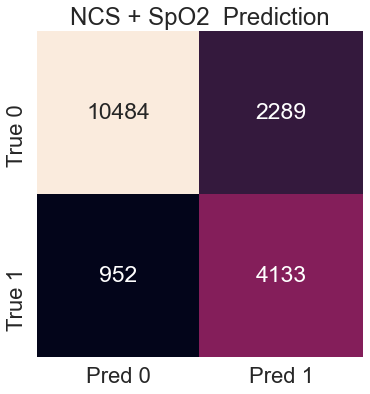

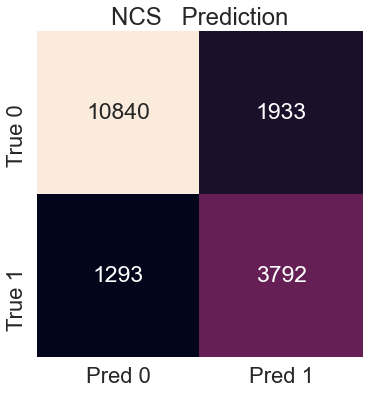

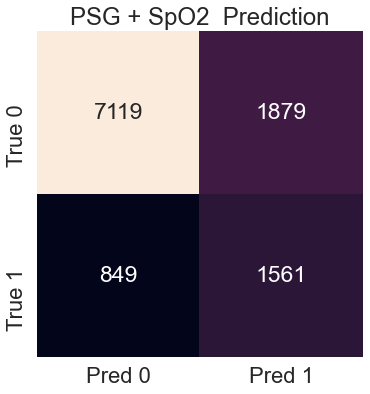

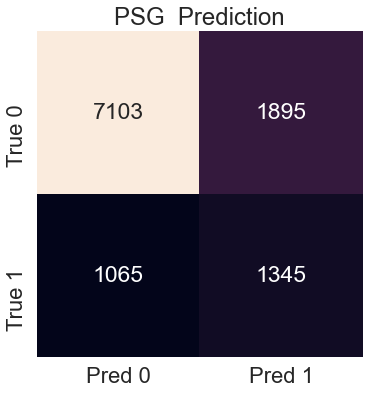

In [35]:
def plotfig(cm,acc,feat,impt,CVmethod,tle):

    labelNum=str(3)  #labelling method 1,2,3,4
    size=18
    name1=["True 0", "True 1"]
    name2=["Pred 0", "Pred 1"]
    w=7 #fig size 1      change when label num change
    h=6   #fig size 2
    a=2   #txt position 1   change when label num change
    b=1   #txt position 2

    sen,pre=cm_parameter(cm)
    df_cm = pd.DataFrame(cm, index=name1, columns=name2)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.figure()
    sn.set(font_scale=2)
    sn.heatmap(df_cm, annot=True,fmt="d",square=True,cbar=False,annot_kws={"size": size,'fontsize':23})

    
    tleSave=CVmethod+tle+ labelNum
    plt.title(tle)

    figure = plt.gcf()
    figure.set_size_inches(w, h)
    FolderSave=r"C:/Users/zz587-admin/Documents/sleep center paper/figure/python/cm_pred/"
    plt.savefig(FolderSave+tleSave+r".png",dpi=300)
    #plt.savefig(FolderSave+tleSave+r".svg")


CVmethod='  k_fold '
tle1='NCS + SpO2  Prediction'
plotfig(cm_NCS_del1,acc_NCS_del1,feat_NCS_del1,impt_NCS_del1,CVmethod,tle1)
tle2='NCS   Prediction'
plotfig(cm_NCS_wo_del1,acc_NCS_wo_del1,feat_NCS_wo_del1,impt_NCS_wo_del1,CVmethod,tle2)
tle3='PSG + SpO2  Prediction'
plotfig(cm_PSG_del1,acc_PSG_del1,feat_PSG_del1,impt_PSG_del1,CVmethod,tle3)
tle4='PSG  Prediction'
plotfig(cm_PSG_wo_del1,acc_PSG_wo_del1,feat_PSG_wo_del1,impt_PSG_wo_del1,CVmethod,tle4)

sen=0.813 spe=0.821
sen=0.746 spe=0.849
sen=0.648 spe=0.791
sen=0.558 spe=0.789
sen=0.805 spe=0.824
sen=0.727 spe=0.853
sen=0.683 spe=0.731
sen=0.626 spe=0.658
sen=0.805 spe=0.824
sen=0.727 spe=0.853
sen=0.683 spe=0.731
sen=0.626 spe=0.658


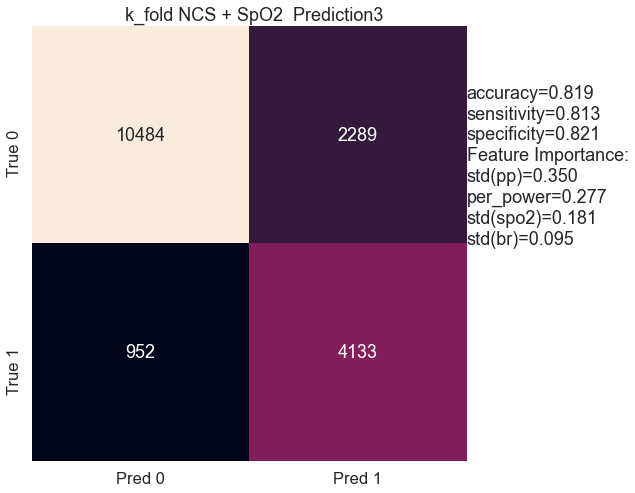

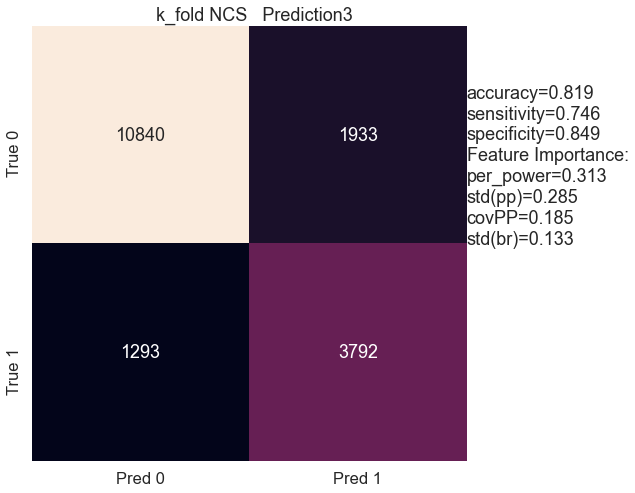

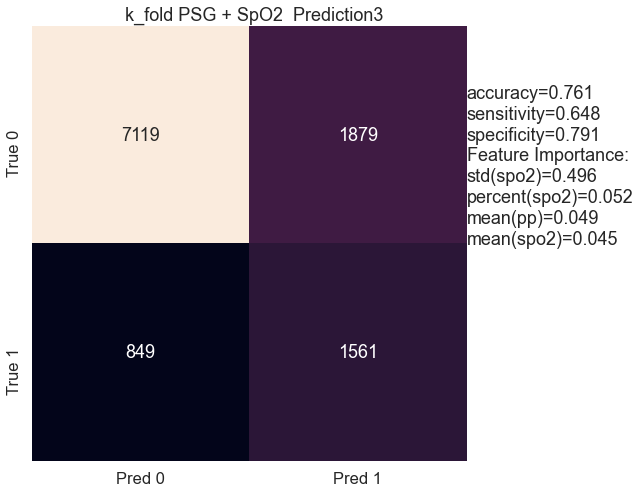

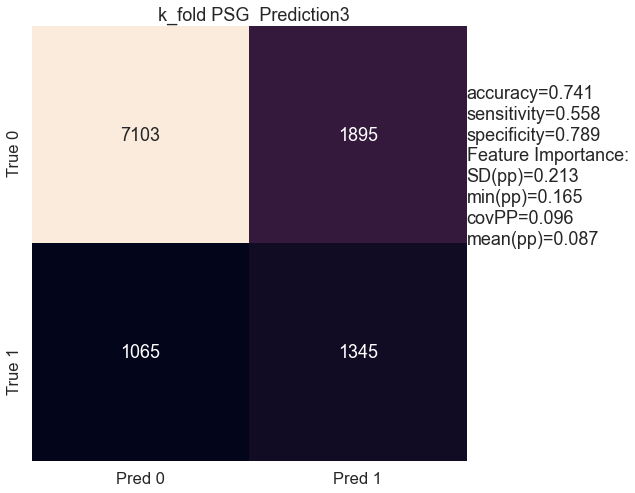

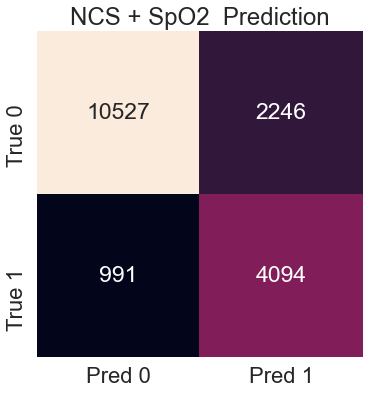

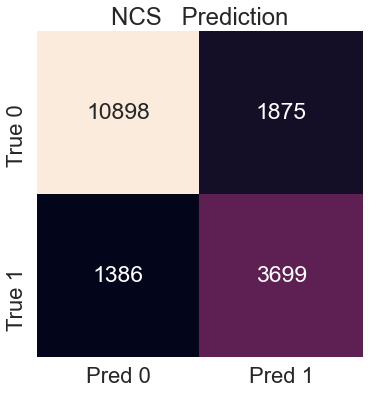

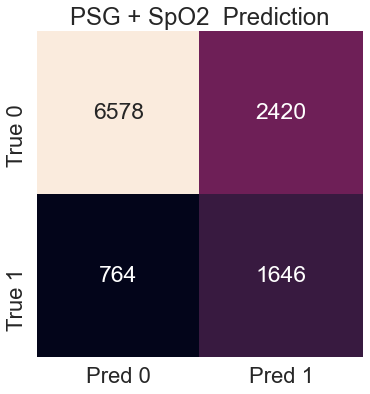

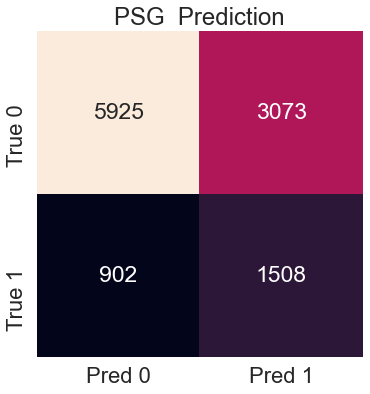

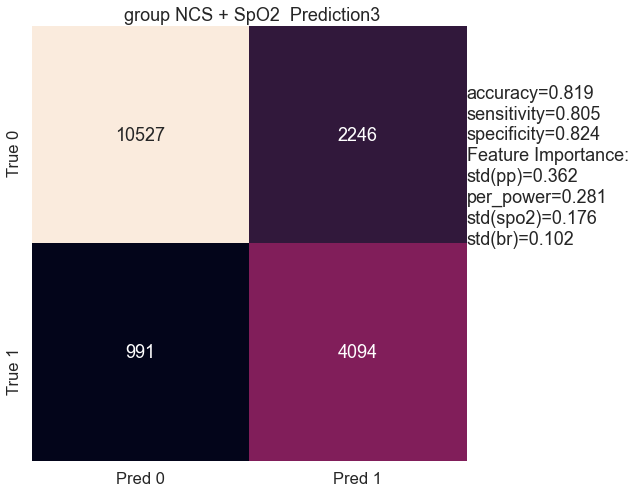

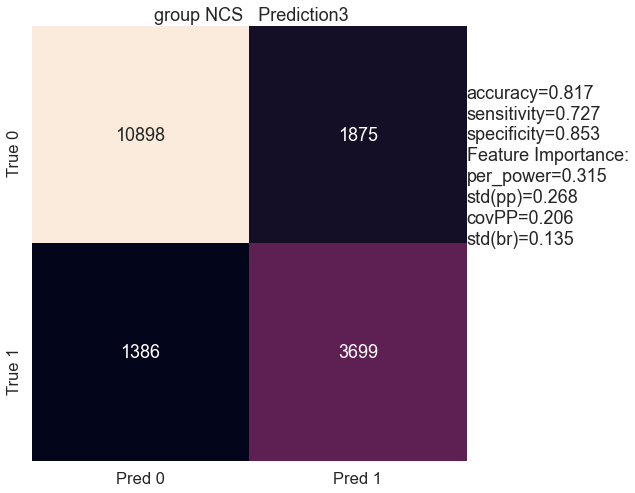

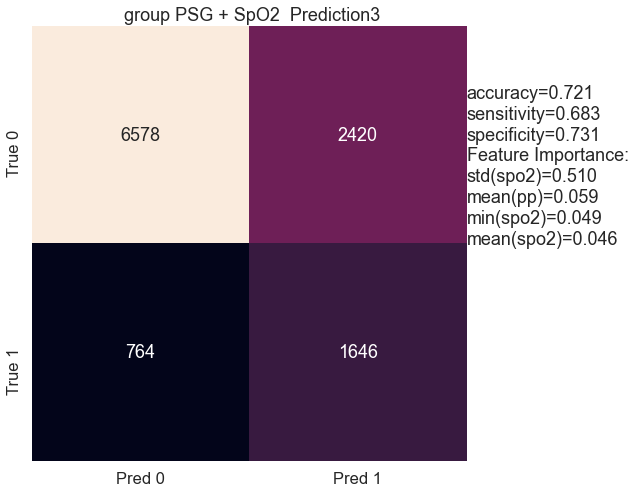

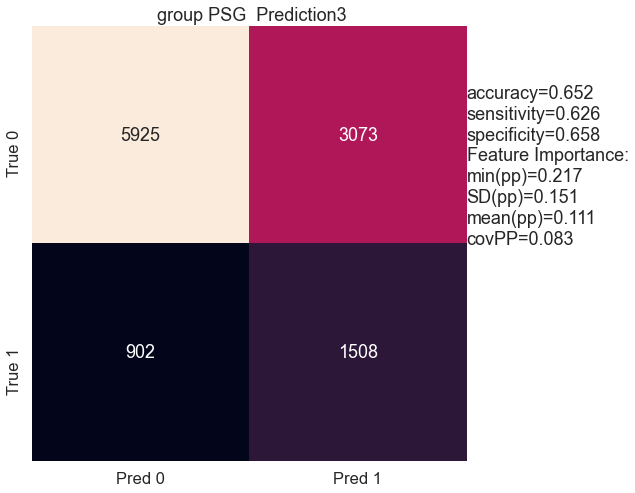

In [36]:
#CVmethod='long features Weighted class1_2.5  group Outlier Removed(0.2) Isolation Forest'
plotfigFull(cm_NCS_del1,acc_NCS_del1,feat_NCS_del1,impt_NCS_del1,CVmethod,tle1)
plotfigFull(cm_NCS_wo_del1,acc_NCS_wo_del1,feat_NCS_wo_del1,impt_NCS_wo_del1,CVmethod,tle2)
plotfigFull(cm_PSG_del1,acc_PSG_del1,feat_PSG_del1,impt_PSG_del1,CVmethod,tle3)
plotfigFull(cm_PSG_wo_del1,acc_PSG_wo_del1,feat_PSG_wo_del1,impt_PSG_wo_del1,CVmethod,tle4)

CVmethod2=' group '
plotfig(cm_NCS_del1_g,acc_NCS_del1_g,feat_NCS_del1_g,impt_NCS_del1_g,CVmethod2,tle1)
plotfig(cm_NCS_wo_del1_g,acc_NCS_wo_del1_g,feat_NCS_wo_del1_g,impt_NCS_wo_del1_g,CVmethod2,tle2)
plotfig(cm_PSG_del1_g,acc_PSG_del1_g,feat_PSG_del1_g,impt_PSG_del1_g,CVmethod2,tle3)
plotfig(cm_PSG_wo_del1_g,acc_PSG_wo_del1_g,feat_PSG_wo_del1_g,impt_PSG_wo_del1_g,CVmethod2,tle4)

plotfigFull(cm_NCS_del1_g,acc_NCS_del1_g,feat_NCS_del1_g,impt_NCS_del1_g,CVmethod2,tle1)
plotfigFull(cm_NCS_wo_del1_g,acc_NCS_wo_del1_g,feat_NCS_wo_del1_g,impt_NCS_wo_del1_g,CVmethod2,tle2)
plotfigFull(cm_PSG_del1_g,acc_PSG_del1_g,feat_PSG_del1_g,impt_PSG_del1_g,CVmethod2,tle3)
plotfigFull(cm_PSG_wo_del1_g,acc_PSG_wo_del1_g,feat_PSG_wo_del1_g,impt_PSG_wo_del1_g,CVmethod2,tle4)

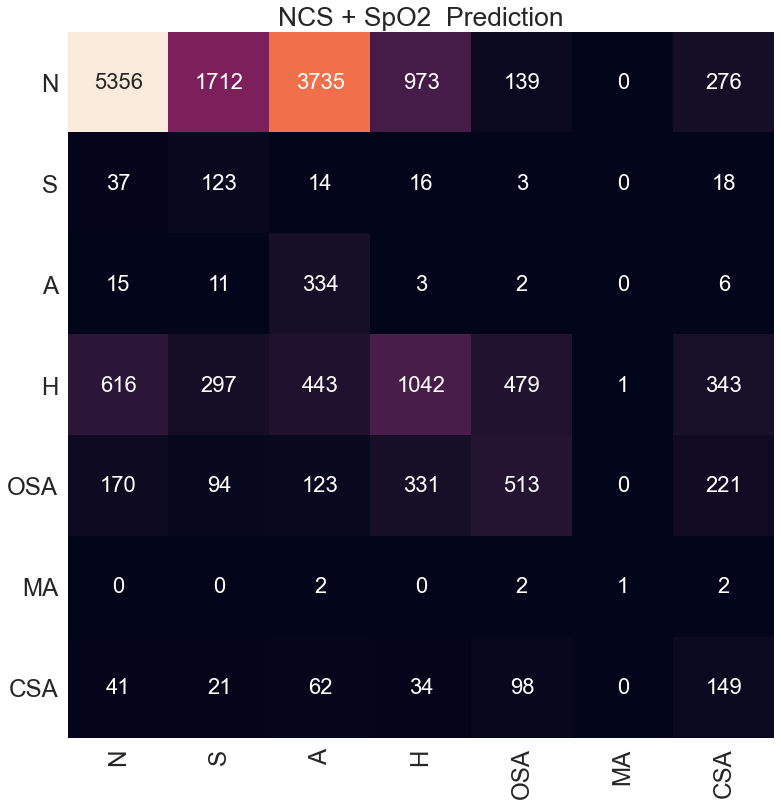

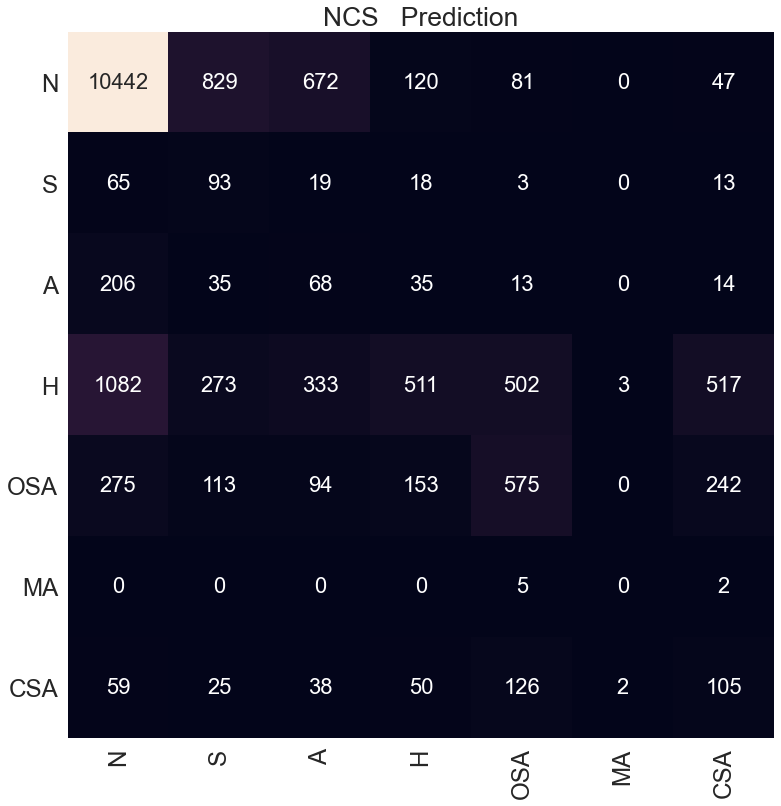

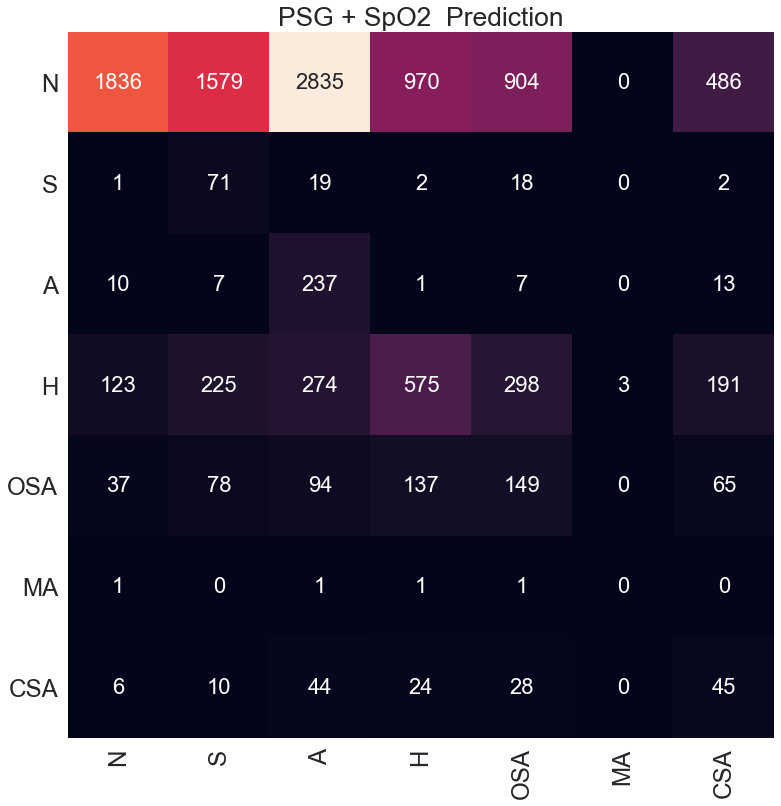

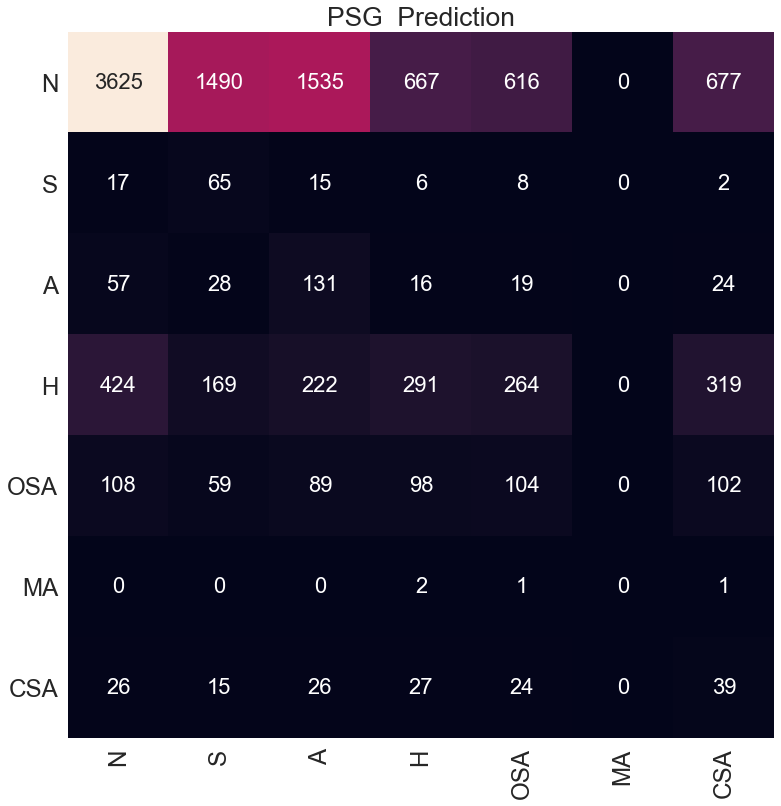

In [37]:
def plotfigFullClass(cm,acc,feat,impt,CVmethod,tle):

    labelNum=str(1)  #labelling method 1,2,3,4
    size=18
    name1=["N", "S","A","H","OSA","MA","CSA"]
    name2=name1
    w=15 #fig size 1      change when label num change
    h=13   #fig size 2
    

    
    df_cm = pd.DataFrame(cm, index=name1, columns=name2)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.figure()
    sn.set(font_scale=2.2)
    sn.heatmap(df_cm, annot=True,fmt="d",square=True,cbar=False,annot_kws={"size": size,'fontsize':22})

    
    tleSave=tle+CVmethod+ labelNum
    plt.title(tle)

    figure = plt.gcf()
    figure.set_size_inches(w, h)
    FolderSave=r"C:/Users/zz587-admin/Documents/sleep center paper/figure/python/cm_pred/"
    plt.savefig(FolderSave+tleSave+r".png",dpi=300)


CVmethod3=' k-fold '
plotfigFullClass(cm_NCS_del1_fc,acc_NCS_del1_fc,feat_NCS_del1_fc,impt_NCS_del1_fc,CVmethod3,tle1)
plotfigFullClass(cm_NCS_wo_del1_fc,acc_NCS_wo_del1_fc,feat_NCS_wo_del1_fc,impt_NCS_wo_del1_fc,CVmethod3,tle2)
plotfigFullClass(cm_PSG_del1_fc,acc_PSG_del1_fc,feat_PSG_del1_fc,impt_PSG_del1_fc,CVmethod3,tle3)
plotfigFullClass(cm_PSG_wo_del1_fc,acc_PSG_wo_del1_fc,feat_PSG_wo_del1_fc,impt_PSG_wo_del1_fc,CVmethod3,tle4)

